# Frank mixtureモデルの最尤推定

In [1]:
!mkdir model

In [704]:
from MIC import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import log, exp

# データのロード

In [14]:
#Load dataset
df = dataloader.load_data_template("trading_jp", start=(2010,1,1),end=(2020,12,31),log_return=True) #currently only support 5 major Japanese trading firms.
df = df.iloc[:,[0,1]] #choose 2 columns.

#Calculate statistics
tau,rho,_,_,_,_= stats.calc_bivar_stats(df)

u=0.05,Threshold: -0.024467936530411016,-0.02729747495029322
λL: 0.6
u=0.01,Threshold: -0.04276695113652451,-0.04886452407856279
λL: 0.6
u=0.05,Threshold: 0.024768513388756297,0.026536754061502243
λU: 0.485
u=0.01,Threshold: 0.040749817674867295,0.04422313120957799
λU: 0.475


In [15]:
tau

SignificanceResult(statistic=0.5767910595606367, pvalue=0.0)

In [16]:
df.head()

,ITOCHU,Marubeni
2010-01-01,0.024194,0.026257
2010-01-02,0.024194,0.026257
2010-01-03,0.024194,0.026257
2010-01-04,0.024194,0.026257
2010-01-05,0.016727,-0.001816


<Axes: >

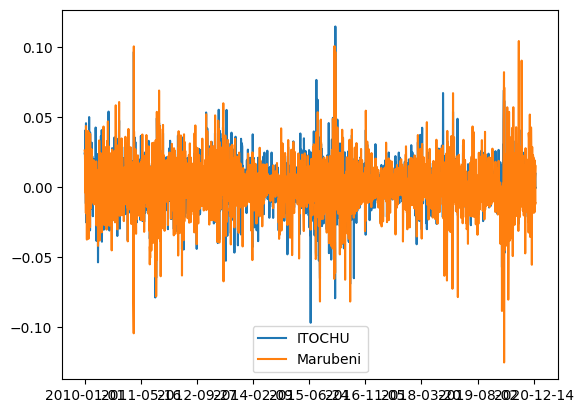

In [17]:
df.plot()

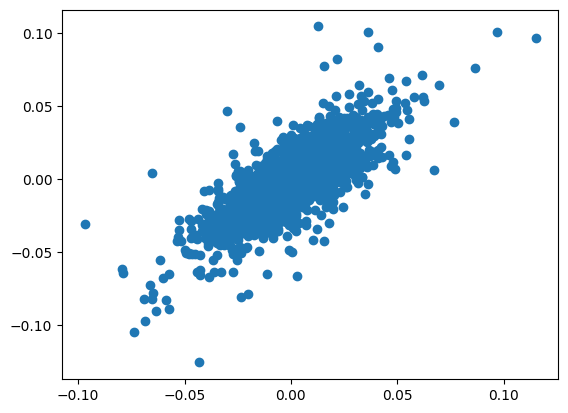

In [18]:
plt.scatter(df.iloc[:,0],df.iloc[:,1])

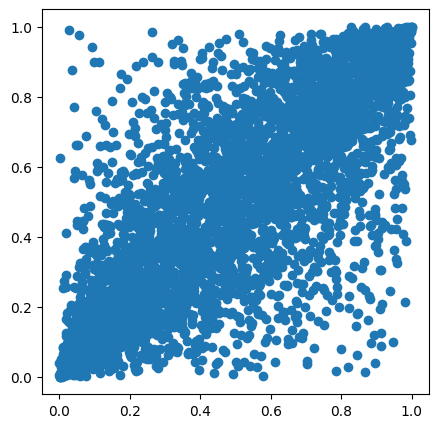

In [19]:
df, _ = dataloader.preprocessing(df)
plt.figure(figsize=(5,5))
plt.scatter(df.iloc[:,0],df.iloc[:,1])

In [588]:
import pandas_datareader.data as web
import datetime
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 12, 31)
eq = web.DataReader('SP500', 'fred', start, end)
dwj = web.DataReader('DJIA','fred', start, end)
nikkei = web.DataReader('NIKKEI225','fred', start, end)
vix = web.DataReader('VIXCLS','fred', start, end)
df = pd.DataFrame(index = eq.index)
#df['SP500'] = eq
#df['DowJones'] = dwj
#df['NIKKEI225'] = nikkei
df['SP500'] = dataloader.log_return(eq,0)
#df['DowJones'] = dataloader.log_return(dwj,0)
df['NIKKEI225'] = dataloader.log_return(nikkei,0)
#df['VIX'] = vix
df.dropna(inplace = True)

In [589]:
df_os, _ = dataloader.preprocessing(df)

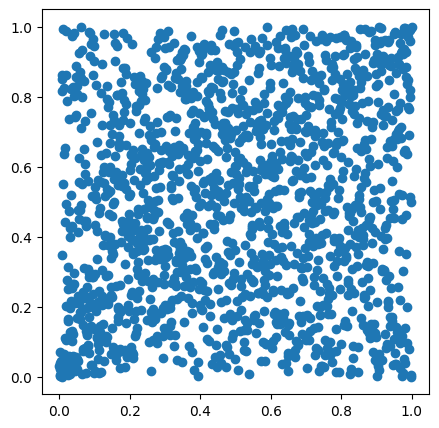

In [590]:
plt.figure(figsize=(5,5))
plt.scatter(df_os.iloc[:,0],df_os.iloc[:,1])

In [591]:
#Calculate statistics
tau,rho,_,_,_,_= stats.calc_bivar_stats(df)
tau

u=0.05,Threshold: -0.01589779340309688,-0.02052184786381674
λL: 0.27848101265822783
u=0.01,Threshold: -0.034510725624696516,-0.0397120097046768
λL: 0.3333333333333333
u=0.05,Threshold: 0.01438343869822631,0.019386682241349113
λU: 0.189873417721519
u=0.01,Threshold: 0.026440929079185473,0.03183169769278117
λU: 0.13333333333333333


SignificanceResult(statistic=0.11170184622537897, pvalue=2.8772184197151958e-11)

In [667]:
#正解
n_ = 30
df_os_copy = df_os.copy()
df_os_copy.columns = ["X","Y"]
keiken_copula = np.zeros((n_,n_))
for i in range(n_):
    for j in range(n_):
        x_thresh = (i+1)/30
        y_thresh = (j+1)/30
        keiken_copula[i][j] = len(df_os_copy.query("(@i)/30 < X < (@i+1)/30 and (@j)/30 < Y < (@j+1)/30"))
keiken_copula = keiken_copula/len(df_os)

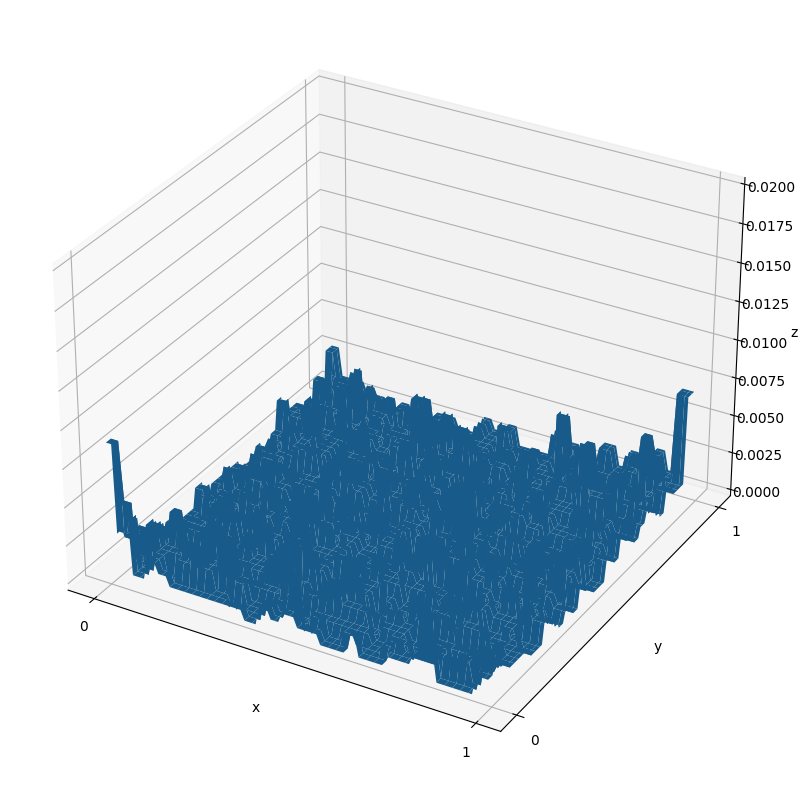

In [703]:
_ = visualize.three_dim_plot_flatten(keiken_copula, top=0.02)

### power-1がL1, L2で測ると最も良いが, 尤度で見るとなぜかpowerが大きいほど良い...

In [702]:
#単純に差を見る.（L1norm)
np.sum(np.abs(keiken_copula - np.load("model/mick-power-1.npy")))
#単純に差を見る.（21norm)
np.sum(np.abs(keiken_copula - np.load("model/mick-power-1.npy"))**2)

0.0007066959675842163

## 分布の作成

In [592]:
#τが0.576, μは3.7
mick = copula.greedy_MICK(size=30,invariance=0.55) #need to convert tau into pseudo log odds ratio

In [482]:
#しっぱい
# def power_ccopula(cop,k):
#     cop = cop ** k
#     cop = cop / cop.sum()
#     #for _ in range(100):
#     while True:
#         # print(cop.sum(axis=0))
#         # print(cop.sum(axis=1))
#         cop = cop/cop.sum(axis=0)
#         # print(cop.sum(axis=0))
#         # print(cop.sum(axis=1))
#         cop = cop.T
#         # print(cop.sum(axis=0))
#         # print(cop.sum(axis=1))
#         cop = cop/cop.sum(axis=0)
#         # print(cop.sum(axis=0))
#         # print(cop.sum(axis=1))
#         if np.all(abs(cop.sum(axis=0)-1)<1e-10) and np.all(abs(cop.sum(axis=1)-1)<1e-10):
#             break
#     return cop

In [593]:
def power_ccopula(cop,k):
    dist = cop**k
    dist = dist/dist.sum()
    n = len(cop)
    fx = dist.sum(axis=0)
    fy = dist.sum(axis=1)
    Fx = []
    tmp = 0
    for i in range(n):
        tmp += fx[i]
        Fx.append(tmp)
    Fy = []
    tmp = 0
    for i in range(n):
        tmp += fy[i]
        Fy.append(tmp)

    
    print(dist)


    def Finv_x(u):
        ind = 0
        while Fx[ind] < u:
            ind += 1
        r = (u-Fx[ind-1])/(Fx[ind]-Fx[ind-1])
        return (1/n)*(ind)

    def Finv_y(u):
        ind = 0
        while Fy[ind] < u:
            ind += 1
        r = (u-Fy[ind-1])/(Fy[ind]-Fy[ind-1])
        return (1/n)*(ind)
    
    res = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            i_ = int(Finv_x((i+0.5)/n)/(1/n))
            j_ = int(Finv_y((j+0.5)/n)/(1/n))
            res[i][j] = dist[i_][j_]/(fx[i_]*fy[j_])*(1/(n**2))
    
    np.save(f"model/mick-power-{k}", res)
    return res

In [594]:
for k in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5]:
    res = power_ccopula(mick,k)

[[0.00116404 0.00116003 0.00115605 0.00115209 0.00114816 0.00114424
  0.00114035 0.00113648 0.00113264 0.00112881 0.00112499 0.0011212
  0.00111742 0.00111365 0.0011099  0.00110615 0.00110241 0.00109868
  0.00109495 0.00109122 0.00108749 0.00108376 0.00108002 0.00107628
  0.00107254 0.00106878 0.00106502 0.00106125 0.00105746 0.00105367]
 [0.00116002 0.00115645 0.0011529  0.00114935 0.0011458  0.00114227
  0.00113875 0.00113523 0.00113172 0.00112821 0.00112471 0.00112122
  0.00111772 0.00111423 0.00111074 0.00110725 0.00110376 0.00110026
  0.00109676 0.00109325 0.00108973 0.0010862  0.00108265 0.0010791
  0.00107553 0.00107195 0.00106835 0.00106473 0.00106109 0.00105744]
 [0.00115602 0.00115288 0.00114973 0.00114658 0.00114342 0.00114026
  0.00113709 0.00113391 0.00113073 0.00112755 0.00112436 0.00112116
  0.00111796 0.00111474 0.00111152 0.00110828 0.00110504 0.00110178
  0.0010985  0.00109521 0.00109191 0.00108858 0.00108524 0.00108187
  0.00107848 0.00107507 0.00107164 0.00106819 0.

[[7.98117651e-03 6.71724371e-03 5.65591586e-03 4.76435902e-03
  4.01507606e-03 3.38504826e-03 2.85501124e-03 2.40884499e-03
  2.03306117e-03 1.71637246e-03 1.44933161e-03 1.22402900e-03
  1.03383973e-03 8.73212069e-04 7.37490858e-04 6.22770021e-04
  5.25769518e-04 4.43732716e-04 3.74340788e-04 3.15641353e-04
  2.65988956e-04 2.23995437e-04 1.88488528e-04 1.58477297e-04
  1.33123295e-04 1.11716455e-04 9.36549256e-05 7.84282066e-05
  6.56030059e-05 5.48113796e-05]
 [6.71227089e-03 5.75506596e-03 4.93351056e-03 4.22860781e-03
  3.62393800e-03 3.10533372e-03 2.66058985e-03 2.27920588e-03
  1.95215831e-03 1.67170042e-03 1.43118685e-03 1.22492061e-03
  1.04801990e-03 8.96302735e-04 7.66187165e-04 6.54605215e-04
  5.58928821e-04 4.76906233e-04 4.06607476e-04 3.46377667e-04
  2.94797096e-04 2.50647137e-04 2.12881152e-04 1.80599685e-04
  1.53029307e-04 1.29504596e-04 1.09452770e-04 9.23805938e-05
  7.78632004e-05 6.55345574e-05]
 [5.64760709e-03 4.92985613e-03 4.30029262e-03 3.74862805e-03
  3.

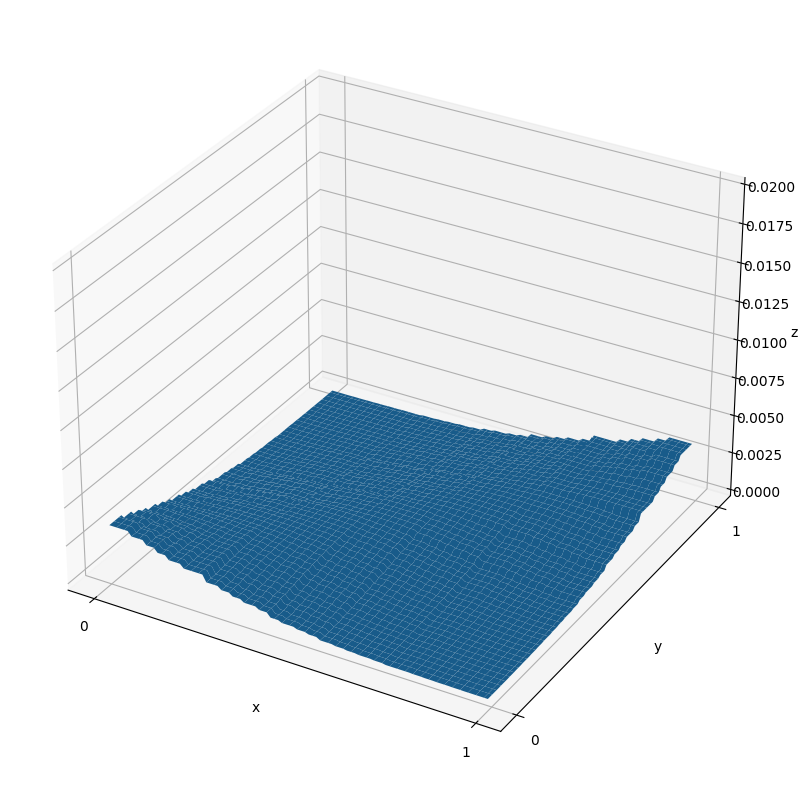

In [670]:
_ =  visualize.three_dim_plot_flatten(power_ccopula(mick,5), top=0.02)

In [596]:
res.sum(axis=0)

array([0.03289405, 0.03289405, 0.0329532 , 0.03302042, 0.03309349,
       0.03317005, 0.03324774, 0.03324774, 0.0333971 , 0.03346436,
       0.0335241 , 0.03357469, 0.0336149 , 0.03366118, 0.03366681,
       0.03366116, 0.03364505, 0.03358623, 0.03354657, 0.03350238,
       0.0334555 , 0.03340777, 0.03331672, 0.03331672, 0.03327661,
       0.03324199, 0.03321403, 0.03319375, 0.03318198, 0.03318198])

# 分布の作成2

In [706]:
def solve_movement_k(theta,x1,x2,x3,x4,k):
   a = 1-exp(theta*(x1+x2+x3+x4))
   b = x1+x4+(x2+x3)*exp(theta*((x1+x2+x3+x4)**k))
   c = x1*x4 - x2*x3*exp(theta*((x1+x2+x3+x4)**k))
   solution = utils.solv_quadratic_equation(a,b,c)
   return solution

def greedy_k(size,invariance,k):
   n = size
   opt = utils.create_uniform((n,n))

   while True: 
      max_delta = 0
      for i in range(n-1):
            for j in range(n-1):
               delta = solve_movement_k(invariance,opt[i][j],opt[i+1][j],opt[i][j+1],opt[i+1][j+1],k)
               opt[i][j] += delta
               opt[i+1][j+1] += delta
               opt[i+1][j] -= delta
               opt[i][j+1] -= delta
               if delta > max_delta:
                  max_delta = delta
      if abs(max_delta) < 1e-7:
            break
   return opt

In [710]:
mick_1 = greedy_k(30,0.55,1)

In [711]:
mick_2 = greedy_k(30,0.55,2)

In [712]:
mick_1_over_2 = greedy_k(30,0.55,1/2)

In [719]:
mick_1_over_3 = greedy_k(30,0.55,1/3)

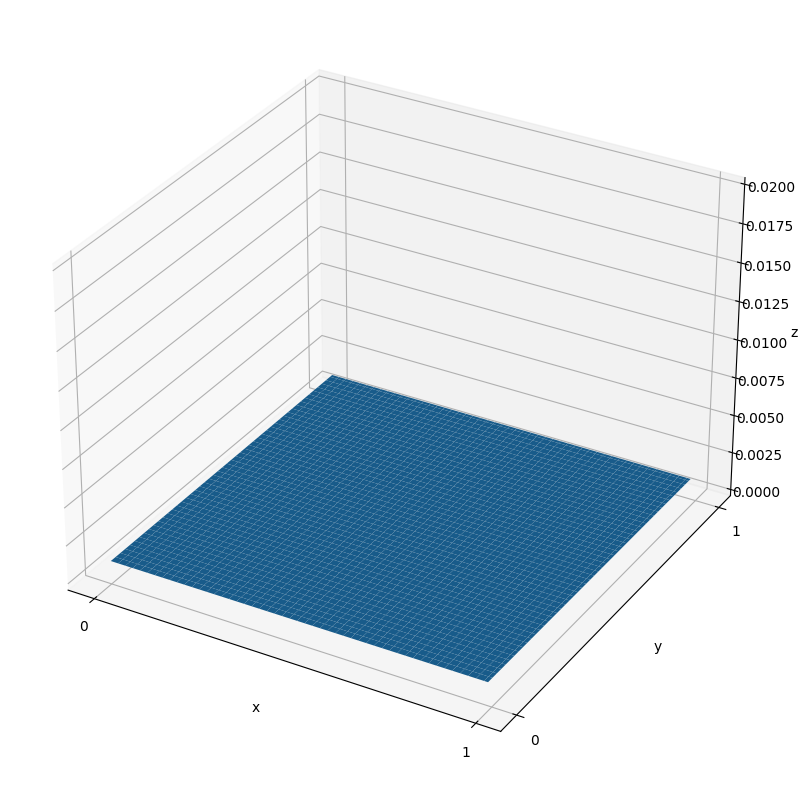

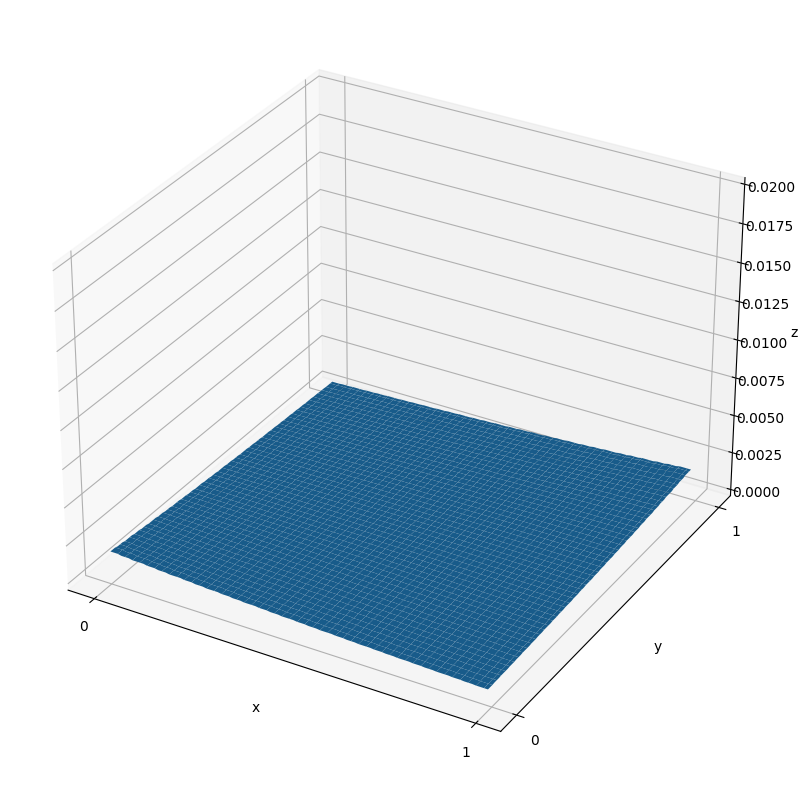

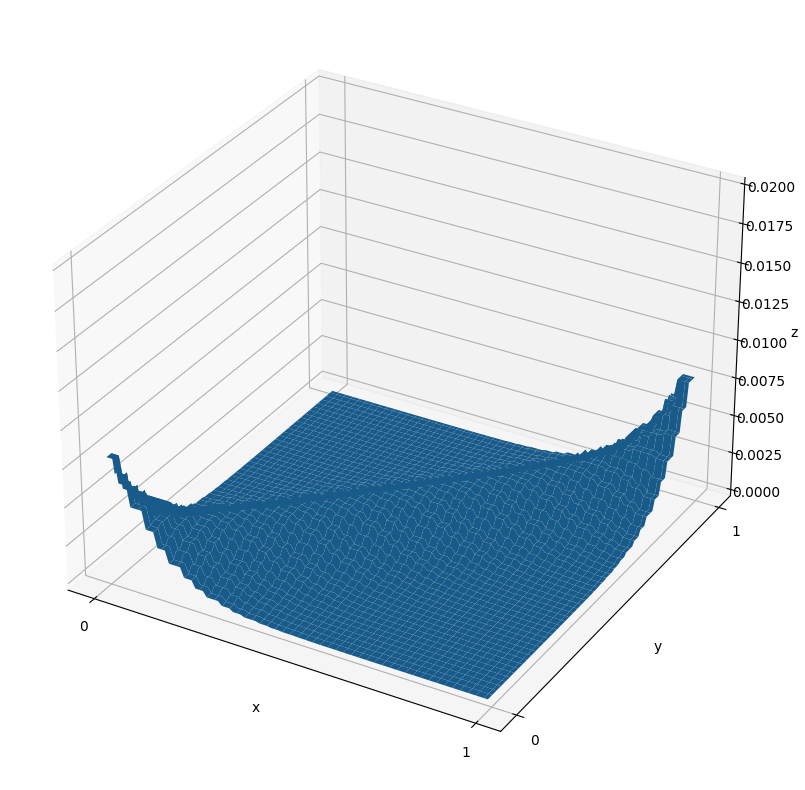

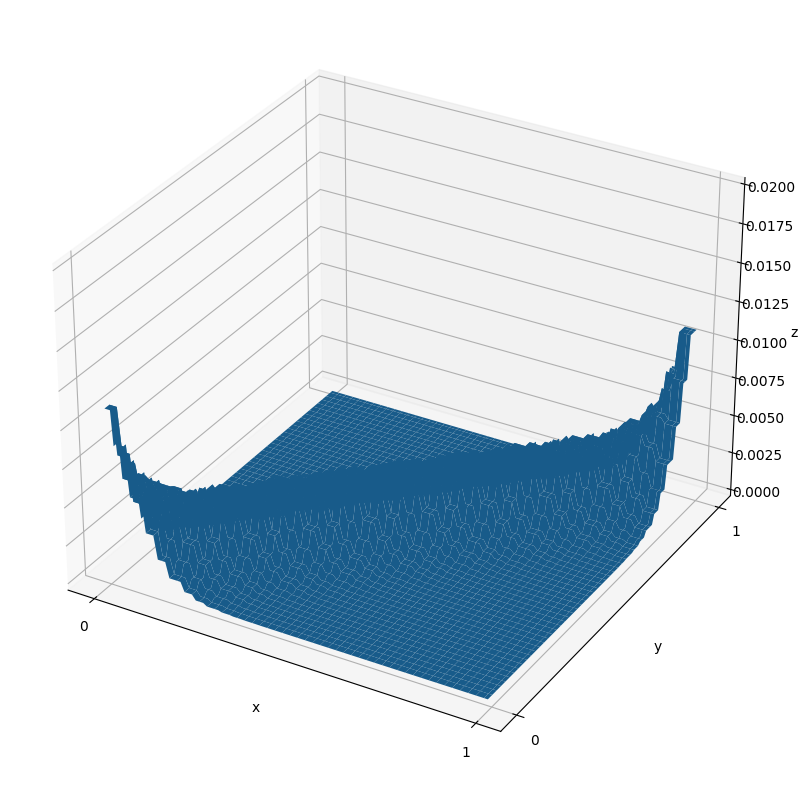

In [720]:
_ = visualize.three_dim_plot_flatten(mick_2, top=0.02)
_ = visualize.three_dim_plot_flatten(mick_1, top=0.02)
_ = visualize.three_dim_plot_flatten(mick_1_over_2, top=0.02)
_ = visualize.three_dim_plot_flatten(mick_1_over_3, top=0.02)

In [723]:
for k in [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5]:
    res = greedy_k(30,0.55,k)
    np.save(f"model/mick-power-{k}", res)

# 混合分布を用いたfitting

とりあえず３種類  
（参考）https://arxiv.org/pdf/1906.09388.pdf

In [792]:
import numpy as np
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
from pyomo.environ import *

In [793]:
model = pyo.ConcreteModel()

In [794]:
# 変数の添字
I = 5
model.I = pyo.Set(initialize=range(1, I+1))
# 変数の定義
model.x = pyo.Var(model.I, domain=pyo.NonNegativeReals)

In [795]:
for i in range(1,I+1):
    model.x[i].value = 0.0
model.x[3].value = 1.0

In [796]:
distributions = [np.load("model/mick-power-0.3.npy"),np.load("model/mick-power-0.5.npy"),np.load("model/mick-power-1.npy"),np.load("model/mick-power-2.npy"),np.load("model/mick-power-3.npy")]

In [797]:
data = df.values
data.shape

(1580, 2)

対数尤度  
$$l = -\sum_i \log{ p(X_i)}$$

In [798]:
def likelihood(sample, ccop):
    x = sample[0]
    y = sample[1]
    n = len(ccop)
    i = int(x/(1/n))
    j = int(x/(1/n))
    return ccop[i][j]/(1/(n**2))

In [799]:
# 目的関数の数式の定義
def ObjRule(model):
    res = 0
    for ind in range(len(data)):
        res = res + log(sum([(model.x[i])*likelihood(data[ind],distributions[i-1]) for i in model.I]))
    #res = sum([(model.x[i])*likelihood(data[0],distributions[i-1]) for i in model.I])
    return -res
# 目的関数として設定
model.obj = pyo.Objective(rule = ObjRule, sense = pyo.minimize)

In [800]:
# 制約1
def Construle1(model):
    return sum([model.x[i] for i in range(1,I+1)]) == 1
model.eq1 = pyo.Constraint(rule = Construle1)

# def Construle2(model):
#     return model.x[1]>= 0
# model.eq2 = pyo.Constraint(rule = Construle2)

# def Construle3(model):
#     return model.x[2]>= 0
# model.eq3 = pyo.Constraint(rule = Construle3)

# def Construle4(model):
#     return model.x[3]>= 0
# model.eq4 = pyo.Constraint(rule = Construle4)

In [801]:
# ソルバーの設定
opt = pyo.SolverFactory('ipopt')
# 最適化の実施
res = opt.solve(model,tee=True)

Ipopt 3.14.12: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.12, running with linear solver MUMPS 5.2.1.

Number of nonzeros in equality constraint Jacobian...:        5
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       15

Total number of variables............................:        5
                     variables with only lower bounds:        5
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        1
Total number

In [802]:
print(res)


Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1
  Number of variables: 5
  Sense: unknown
Solver: 
- Status: ok
  Message: Ipopt 3.14.12\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.026295900344848633
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



In [803]:
for k in range(1,I+1):
    print(model.x[k]())

1.0000000389120955
-9.478899184212599e-09
-9.803167451030482e-09
-9.815014374949732e-09
-9.815014427998267e-09


In [804]:
model.obj()

-3710.39281466822

# misc.

In [175]:
dist = mick**2
dist = dist/dist.sum()
n = len(mick)
fx = dist.sum(axis=0)
fy = dist.sum(axis=1)
Fx = []
tmp = 0
for i in range(n):
    tmp += fx[i]
    Fx.append(tmp)
Fy = []
tmp = 0
for i in range(n):
    tmp += fy[i]
    Fy.append(tmp)


def Finv_x(u):
    ind = 0
    while Fx[ind] < u:
        ind += 1
    # print(ind)
    # print(Fx[ind-1],Fx[ind]) #uはこの間
    r = (u-Fx[ind-1])/(Fx[ind]-Fx[ind-1])
    return (1/n)*(ind)

def Finv_y(u):
    ind = 0
    while Fy[ind] < u:
        ind += 1
    # print(ind)
    # print(Fx[ind-1],Fx[ind]) #uはこの間
    r = (u-Fy[ind-1])/(Fy[ind]-Fy[ind-1])
    return (1/n)*(ind)

In [181]:
cop = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        i_ = int(Finv_x((i+0.5)/n)/(1/n))
        j_ = int(Finv_y((j+0.5)/n)/(1/n))
        cop[i][j] = dist[i_][j_]/(fx[i_]*fy[j_])*(1/(n**2))

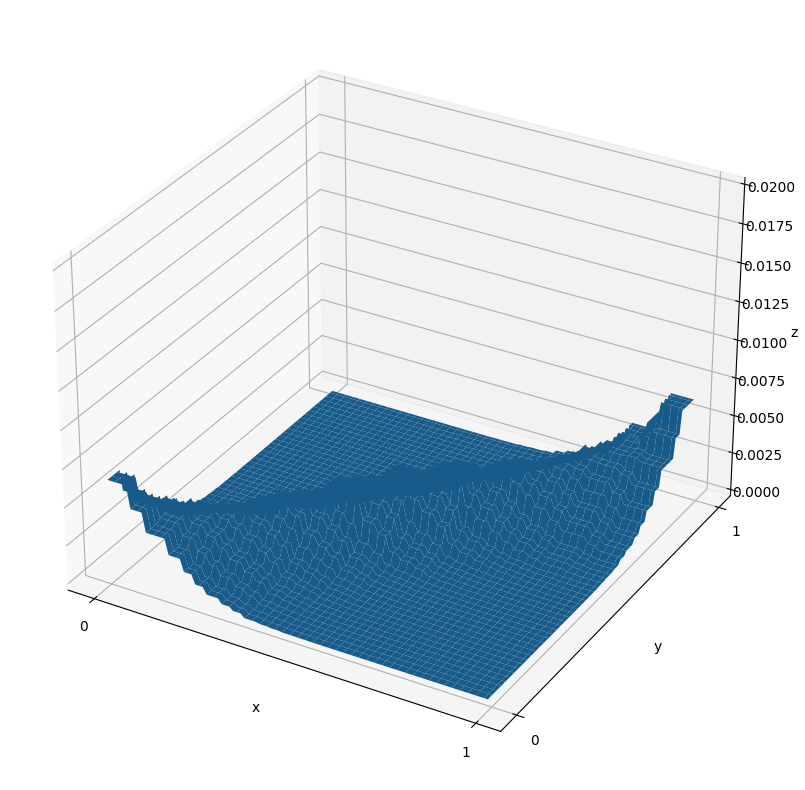

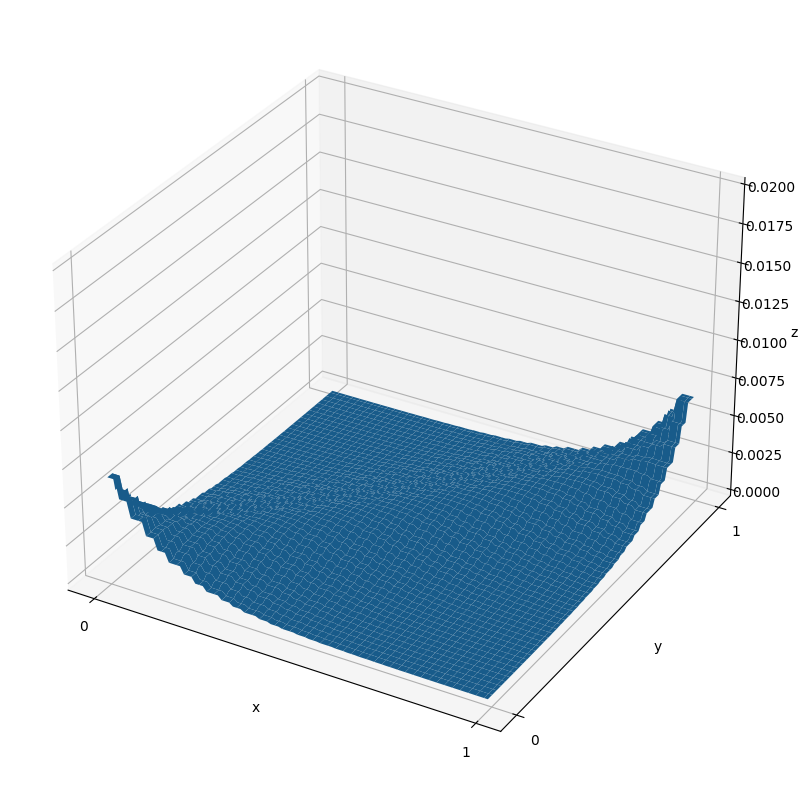

In [189]:
_ =  visualize.three_dim_plot_flatten(cop, top=0.02)
_ = visualize.three_dim_plot_flatten(mick, top=0.02)

# 最適化

In [2]:
import numpy as np
import pyomo.environ as pyo
from pyomo.opt import SolverFactory

In [3]:
# 変数の数
I = 2
#
# データ（係数など）
## 目的変数の係数
a_data = np.array([4, 0.25])
## ベクトル（各制約式の下限）
lower_data = np.array([0.5, 2])#
# 辞書(dictionary)へ変換
a = dict((i, a_data[i-1]) for i in range(1,I+1))
## ベクトル（各制約式の下限）
lower = dict((i, lower_data[i-1]) for i in range(1,I+1))

In [4]:
model = pyo.ConcreteModel()

In [5]:
# 変数の添字
model.I = pyo.Set(initialize=range(1, I+1))
# 変数の定義
model.x = pyo.Var(model.I)

In [6]:
# 目的関数の数式の定義
def ObjRule(model):
    return sum(a[i] * (model.x[i])**2 for i in model.I)
# 目的関数として設定
model.obj = pyo.Objective(rule = ObjRule, sense = pyo.minimize)

In [7]:
# 制約1
def Construle1(model):
    return model.x[1]*model.x[2] >= 1
model.eq1 = pyo.Constraint(rule = Construle1)
# 制約2
def Construle2(model, i):
    return model.x[i] >= lower[i]
model.eq2 = pyo.Constraint(model.I, rule = Construle2)

In [8]:
# ソルバーの設定
opt = pyo.SolverFactory('ipopt')
# 最適化の実施
res = opt.solve(model)

In [9]:
print(model.display())
print('\n')
print('optimum value = ', model.obj())
print("x = ", model.x[:]())

Model unknown

  Variables:
    x : Size=2, Index=I
        Key : Lower : Value               : Upper : Fixed : Stale : Domain
          1 :  None : 0.49999999558007313 :  None : False : False :  Reals
          2 :  None :  2.0000000022840774 :  None : False : False :  Reals

  Objectives:
    obj : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 1.99999998460437

  Constraints:
    eq1 : Size=1
        Key  : Lower : Body              : Upper
        None :   1.0 : 0.999999992302185 :  None
    eq2 : Size=2
        Key : Lower : Body                : Upper
          1 :   0.5 : 0.49999999558007313 :  None
          2 :   2.0 :  2.0000000022840774 :  None
None


optimum value =  1.99999998460437
x =  [0.49999999558007313, 2.0000000022840774]
